In [160]:
import pandas as pd
import numpy as np

df = pd.read_csv('/home/macrodrigues/code/macrodrigues/skills_matcher/data/cleaned_data.csv')
df = df.dropna()

In [161]:
df.head()

,Unnamed: 0,ISCO,major_job,job,position,location,description
0,0,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",You have an academic degree in physics or eng...
1,1,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Applied Physicist (Computing) (EP-LBC-2021-125...,Geneva,Be in charge of the development of applicatio...
2,2,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist (BE-ABP-LNO-2021-122-LD)...,Geneva,Contribute to the maintenance and development...
3,3,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Medical Devices Physicist,"Newton, Cambridgeshire",Agency: Newton Colmore Consulting Reference: ...
4,4,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Fluidics Physicist,Cambridge,Agency: Newton Colmore Consulting Reference: ...


In [162]:
import spacy
from spacy import displacy
from spacy.tokens import Span

nlp = spacy.load("en_core_web_sm")

raw_text= df.description[0]
doc = nlp(raw_text)

# Create a span for the new entity
fb_ent = Span(doc, 4, 8, label="GRADUATION")
orig_ents = list(doc.ents)

doc.ents = orig_ents + [fb_ent]
ents = [(e.text, e.start, e.end, e.label_) for e in doc.ents]
#print(ents)
displacy.serve(doc, style="ent")

/home/macrodrigues/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/spacy/displacy/__init__.py:98: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


## Labeling

In [159]:
list_of_graduations = ['post graduate experience',
                       'Educational background in Linguistics, Philology',
                       "Master's degree in Chemistry, Industrial Chemistry or Chemical Engineering",
                       'teaching degree',
                       'Physiotherapy degree (MSc or BSc)',
                       'master degree in business or marketing orientation',
                       'relevant discipline Technical/engineering background',
                       'High school',
                       'ideally with a PhD',
                       'Degree in Science or related Quality discipline',
                       "Three to five years’ experience in a healthcare industry",
                       'Mechanical background with industry',
                       'Degree in Agriculture',
                       'BSc or MSc degree in Engineering or Computer Science',
                       'MQF level 6 Degree in Communication Therapy',
                       'BSc in Clinical Physiology',
                       'University of Applied Science education in a software-related field',
                       'Ph.D. in Microbiology, Microbial Genetics, Biochemistry or related field',
                       'Bachelor’s Degree or higher',
                       'Systems Engineering studies background',
                       'Ph.D. in Organic Synthesis is desirable',
                       'strong academics in physics or a closely related field',
                       
                       
                       
                       
                       
                       
                     
                       
                      ]

list_of_experiences = ['2 years Software development',
                       '1 year(s) post graduate experience',
                       '1−2 years of experience in content and tech writing',
                       '1-2 years of academic or industrial work experience',
                       'experience in a client-facing role in a shop',
                       'minimum of 12-18 months of ESP experience',
                       "3 to 5 years' experience in the FMCG environment",
                       'experience of installing, repairing or maintaining',
                       'working on novel biochemistry',
                       'Three to five years’ experience in a healthcare industry',
                       '3+ years of proven experience in software and/or hardware testing',
                       'industry knowledge will be beneficial but not essential',
                       'Extensive experience in the operation of FPGAs and optoelectronics',
                       'Experience with Trigger and Data Acquisition systems',
                       'At least 3 years of experience with embedded systems'
                       '2 years in the field of cybersecurity',
                       'Minimum of 2 years, post-graduation experience',
                       'At least 3 years of industry experience in mechatronic development',
                       'Minimum of 3 years of experience in an industrial or research lab',
                       'minimum of 5 years experience in administrative services or education',
                       '4-5 years experience of managing large medical/association/academic conferences',
                       'from 1.5 of experience in video editing',
                       
                       
                       
                       
                       
                       
                      ]

## Build Training Set

To train a model, you first need training data – examples of text, and the labels you want the model to predict. This could be a part-of-speech tag, a named entity or any other information.

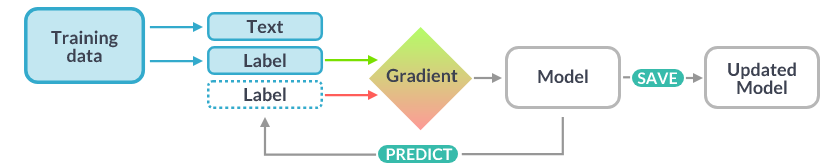

In [1]:
import re
import pandas as pd
import spacy
from spacy.util import filter_spans
from spacy.tokens import Span
from spacy.matcher import Matcher
from spacy import displacy
from IPython.display import HTML, display

df = pd.read_csv('/home/macrodrigues/code/macrodrigues/skills_matcher/data/cleaned_data.csv')
df = df.dropna()
nlp = spacy.load("en_core_web_sm")
# skills = pd.read_csv('/home/macrodrigues/code/macrodrigues/skills_matcher/data/tech_skills.csv')
# skills = list(skills['0'].values)

2021-12-01 21:52:11.890878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-01 21:52:11.890969: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
def highlight_terms(terms, texts):
    for doc in nlp.pipe(texts):
        for sentence in [tok.doc for tok in doc if tok.lower_ in terms]:
            text = sentence.text.strip()
            markup = re.sub(fr'(?i)\b({"|".join(terms)})\b', r'<strong>\1</strong>', text)
            display(HTML(markup))

In [12]:
highlight_terms(['experience', 'knowledge', 'expertise', 'You have'], df.description.values[0:1])

In [6]:
params = ['experience', 'knowledge', 'expertise', 'You have']


def extract_noun_phrase_experience(doc):
    for np in doc.noun_chunks:
        print(np)
        if np[-1].lower_ in params:
            if len(np) > 1:
                yield str(np[-1].lower_) , np[0].i, np[-1].i
                
def extract_adp_experience(doc):
    for tok in doc:
        if tok.lower_ in params:
            for child in tok.rights:
                if child.dep_ == 'prep':
                    for obj in child.children:
                        if obj.dep_ == 'pobj':
                            yield str(tok.lower_), obj.left_edge.i, obj.i+1
                
                
def show_extraction(examples, *extractors):
    seen = set()
    for doc in nlp.pipe(examples):
        doc.ents = filter_spans([Span(doc, start, end, label) for extractor in extractors for label, start, end in extractor(doc)])
        for tok in doc:
            if tok.lower_ == 'experience':
                sentence = tok.doc
                if sentence.text in seen:
                    continue
                seen.update([sentence.text])
                if not sentence.ents:
                    doc.ents = list(doc.ents) + [Span(doc, tok.i, tok.i+1, 'MISSING')]
                displacy.render(sentence, style='ent', options = {'colors': {'MISSING': 'pink',
                                                                            'EXPERIENCE': 'lightgreen'}})
                

In [7]:
show_extraction(df.description.values[0:3], extract_adp_experience)